# Jared Godar Regression Project

This is the overall working notebook used to acquire / prepare / clean / scale / and explore my zillo data.

The modeling and evaluation portion will be in a second notebook `zillo-modeling.ipynb`

Streamlined highlights from both notebooks can be found in the `zillo-report.ipynb` notebook.

Import libraries used in project.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np 

#Vizualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling Tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

#Custim functiona
from env import host, user, password #Database credentials
import zillo_wrangle


---

## Acquire

In [2]:
# function to contact database
def get_db_url(db_name):
    return f"mysql+pymysql://{user}:{password}@{host}/{db_name}"

- Look at zillow data dictionary. 
- Import minimum features (beds, bath, tax, year, fips)
- See what other columns may prove useful in model


In [3]:
dd = pd.read_excel('zillow_data_dictionary.xlsx')
dd

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home
5,'buildingqualitytypeid',Overall assessment of condition of the buildi...
6,'buildingclasstypeid',"The building framing type (steel frame, wood f..."
7,'calculatedbathnbr',Number of bathrooms in home including fractio...
8,'decktypeid',Type of deck (if any) present on parcel
9,'threequarterbathnbr',Number of 3/4 bathrooms in house (shower + si...


### Takeaways: Columns of interest that may have predictive value

- `buildingqualitytypeid` Quality 
- `fireplacecnt`
- `garagecarcnt`
- `poolcnt`
- `rawcensustractandblock`
- `censustractandblock`
- `regionidzip`
- `regionidneighborhood`
- `storytypeid`


import:
- `regionidcounty`
- 
- `

Use SQL query to get single unit (`propertylandusetypeid=261`) from May-Aug, 2017 filtering for non-zero values to have fewer nulls in the first data pull to deal with.

In [4]:
def get_data_from_sql():
    query = """
    SELECT bedroomcnt as bedrooms, 
       bathroomcnt as bathrooms,
       calculatedfinishedsquarefeet as square_feet,
       yearbuilt as year,
       taxamount as taxes,
       taxvaluedollarcnt as home_value,
       propertylandusedesc, 
       fips as fips,
       regionidzip as zip_code,
       regionidcounty as county,
       regionidcity as city,
       regionidzip as zip,
       regionidneighborhood as neighborhood
    FROM predictions_2017
    JOIN properties_2017 USING(id)
    JOIN propertylandusetype USING(propertylandusetypeid)
    WHERE (transactiondate >= '2017-05-01' AND transactiondate < '2017-09-01') 
        AND propertylandusetypeid = '261'
        AND bedroomcnt > 0
        AND bathroomcnt > 0
        AND calculatedfinishedsquarefeet > 0 
        AND taxamount > 0
        AND taxvaluedollarcnt > 0
        AND fips > 0
    ORDER BY fips;
    """
    df = pd.read_sql(query, get_db_url('zillow'))
    return df

In [5]:
zillow = get_data_from_sql()
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,propertylandusedesc,fips,zip_code,county,city,zip,neighborhood
0,4.0,3.0,2286.0,1985.0,4204.91,350853.0,Single Family Residential,6037.0,96494.0,3101.0,39308.0,96494.0,763171.0
1,3.0,3.0,2915.0,1981.0,5937.01,502511.0,Single Family Residential,6037.0,96494.0,3101.0,39308.0,96494.0,NaN
2,5.0,3.0,4046.0,1998.0,11415.25,920606.0,Single Family Residential,6037.0,96494.0,3101.0,39308.0,96494.0,763171.0
3,4.0,3.0,3895.0,1997.0,13780.74,1173384.0,Single Family Residential,6037.0,96494.0,3101.0,39308.0,96494.0,NaN
4,5.0,4.0,4845.0,1998.0,16442.99,1409059.0,Single Family Residential,6037.0,96494.0,3101.0,39308.0,96494.0,763170.0


Count nulls by column

In [7]:
zillow.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30399 entries, 0 to 30398
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             30399 non-null  float64
 1   bathrooms            30399 non-null  float64
 2   square_feet          30399 non-null  float64
 3   year                 30388 non-null  float64
 4   taxes                30399 non-null  float64
 5   home_value           30399 non-null  float64
 6   propertylandusedesc  30399 non-null  object 
 7   fips                 30399 non-null  float64
 8   zip_code             30374 non-null  float64
 9   county               30399 non-null  float64
 10  city                 29861 non-null  float64
 11  zip                  30374 non-null  float64
 12  neighborhood         10981 non-null  float64
dtypes: float64(12), object(1)
memory usage: 3.0+ MB


In [9]:
# get total of null values for each row
zillow.isnull().sum()

bedrooms                   0
bathrooms                  0
square_feet                0
year                      11
taxes                      0
home_value                 0
propertylandusedesc        0
fips                       0
zip_code                  25
county                     0
city                     538
zip                       25
neighborhood           19418
dtype: int64

Lots of missing neighborhood data... Drop that column before filtering NAs.

- [ ] Drop city as well
- [ ] Figure out how to get that information from `fips`  

### Vizualize distribution and outliers

- Eliminating outliers may also reduce the null value counts

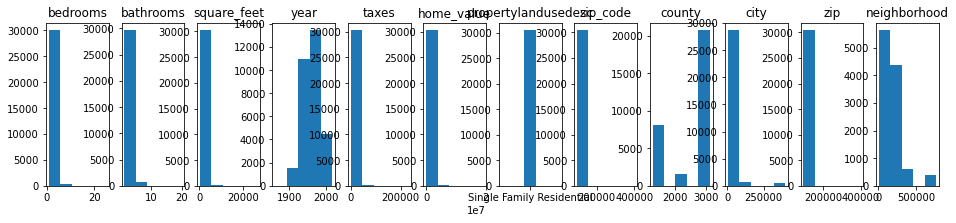

In [12]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    zillow[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

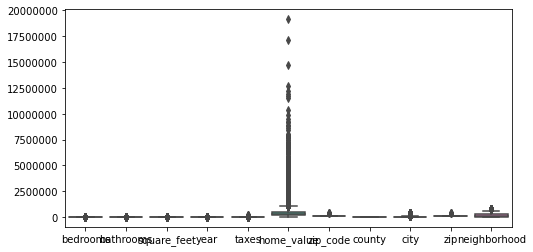

In [13]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=zillow.drop(columns=['fips']))

plt.show()

Lots of outliers

In [14]:
zillow.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))


,bedrooms,bathrooms,square_feet,year,taxes,home_value,fips,zip_code,county,city,zip,neighborhood
count,30399,30399,30399,30388,30399,30399,30399,30374,30399,29861,30374,10981
mean,3.29567,2.23356,1849.61,1960.2,5535.83,454218,6046.74,96576.7,2563,35978.6,96576.7,188182
std,0.927827,0.987157,953.331,21.6526,6765.07,586566,17.9183,4279.34,803,54521.5,4279.34,159460
min,1,1,320,1862,49.18,9762,6037,95982,1286,3491,95982,6952
25%,3,2,1253,1949,2509.11,185388,6037,96186,1286,12447,96186,41466
50%,3,2,1615,1957,4105.28,327336,6037,96383,3101,24832,96383,118872
75%,4,3,2193,1974,6369.06,531602,6059,96981,3101,45457,96981,274750
max,25,20,26345,2016,228999,1.91298e+07,6111,399675,3101,396556,399675,764166


### Remove outliers

Make remove outliers function

In [15]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [16]:
zillow.dtypes

bedrooms               float64
bathrooms              float64
square_feet            float64
year                   float64
taxes                  float64
home_value             float64
propertylandusedesc     object
fips                   float64
zip_code               float64
county                 float64
city                   float64
zip                    float64
neighborhood           float64
dtype: object

In [17]:
zillow = remove_outliers(zillow, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'taxes', 'home_value'])
zillow.head()

,bedrooms,bathrooms,square_feet,year,taxes,home_value,propertylandusedesc,fips,zip_code,county,city,zip,neighborhood
0,4.0,3.0,2286.0,1985.0,4204.91,350853.0,Single Family Residential,6037.0,96494.0,3101.0,39308.0,96494.0,763171.0
1,3.0,3.0,2915.0,1981.0,5937.01,502511.0,Single Family Residential,6037.0,96494.0,3101.0,39308.0,96494.0,NaN
6,3.0,3.0,2230.0,1960.0,5279.42,413802.0,Single Family Residential,6037.0,96505.0,3101.0,24384.0,96505.0,NaN
7,4.0,3.0,2077.0,1977.0,5873.24,458790.0,Single Family Residential,6037.0,96505.0,3101.0,24384.0,96505.0,NaN
8,4.0,3.0,2155.0,1988.0,5166.09,377413.0,Single Family Residential,6037.0,96505.0,3101.0,24384.0,96505.0,NaN


In [18]:
# get total of null values for each row
zillow.isnull().sum()

bedrooms                   0
bathrooms                  0
square_feet                0
year                       8
taxes                      0
home_value                 0
propertylandusedesc        0
fips                       0
zip_code                  12
county                     0
city                     403
zip                       12
neighborhood           17055
dtype: int64

In [19]:
zillow.shape

(26452, 13)

### Vizualize distributions again minus outliers

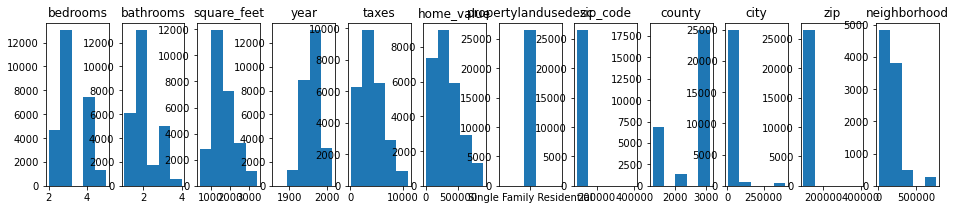

In [20]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    zillow[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    #plt.ticklabel_format(useOffset=False)
    
plt.show()

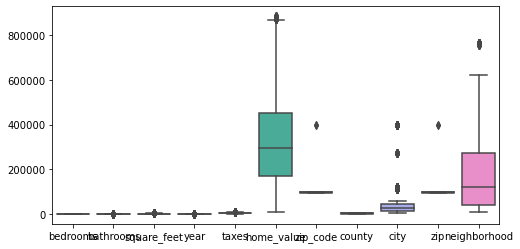

In [21]:
plt.figure(figsize=(8,4))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=zillow.drop(columns=['fips']))

plt.show()

ValueError: could not convert string to float: 'Single Family Residential'

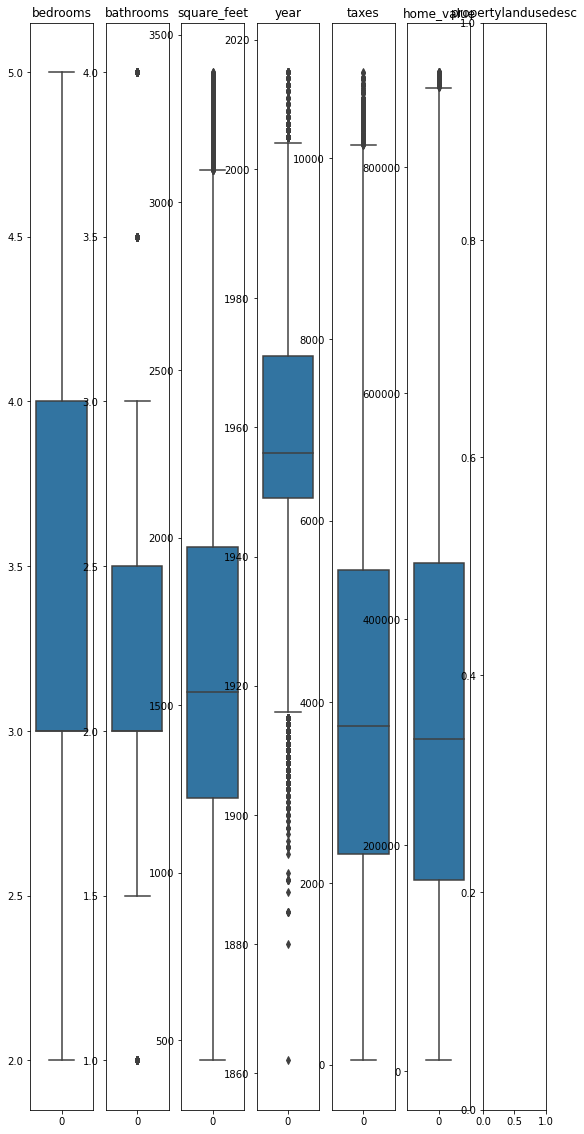

In [22]:
# List of columns
cols = [col for col in zillow.columns if col not in ['fips', 'year_built']]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=zillow[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

In [23]:
zillow.dtypes

bedrooms               float64
bathrooms              float64
square_feet            float64
year                   float64
taxes                  float64
home_value             float64
propertylandusedesc     object
fips                   float64
zip_code               float64
county                 float64
city                   float64
zip                    float64
neighborhood           float64
dtype: object

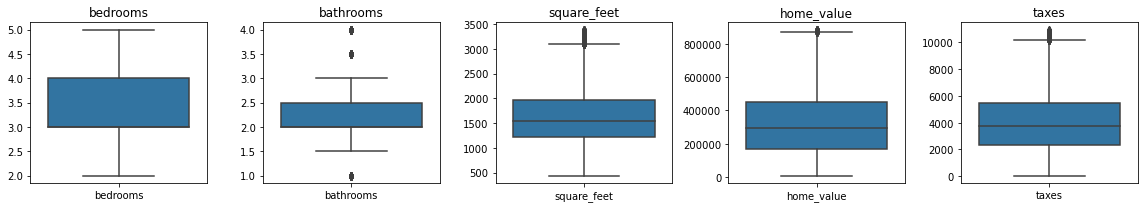

In [25]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'square_feet', 'home_value', 'taxes']

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=zillow[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

In [ ]:
# function to clean up my zillow df
def clean_data(df):
    '''
    This funciton takes in the zillow df and drops observations with Null values
    and handles data types returning a df with a basic clean.
    '''
    df = df.dropna()
    df["fips"] = df["fips"].astype(int)
    df["propertylandusedesc"] = df["propertylandusedesc"].astype("category")
    df["zip_code"] = df["zip_code"].astype("category")
    df["square_feet"] = df["square_feet"].astype("int")
    return df

In [ ]:
print(zillow.shape)

Insert code here to vizualize NA's by column... lsot 2/3 of our records with current filtering. May be a way to impute or preserve or eliminate a problem column.

In [ ]:
#Vizualize NA by column

In [ ]:
zillow = clean_data(zillow)
print(zillow.shape)
zillow.head()

In [ ]:
zillow.describe().T

### To Do:

- [ ] (for unchecked checkbox)
- [x] (for checked checkbox)


- [ ] Add column for range...
- [ ] Import additional columns of potential use
- [ ] Derive columns from there
    - Pool (boolean)
    - Condition (bins)
    - Calculate age in years
    - Bin ages
    - Etc.
- [ ] Lookup / populate county based on `fips`
- [ ] Caculate tax rate percent (`taxes`, `home_value`)


-[ ] Add "inferred single family residential" code to original SQL query

- [ ] left join on propertylandusetype

